# Dataset Build

This notebook will go through my target selection process step by step to make sure the selections and cuts are fully transparent.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib
sns.set_palette('colorblind',10)
sns.set_context('notebook')
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20)
matplotlib.rc('axes',labelsize=20) 
from astropy.table import Table

I'll be using the function below to remove duplicates thoughout this code.

In [2]:
def kill_duplicates(df,ID, sep):
    df = df.copy(deep=True)
    sel = df.duplicated(ID, keep=False)
    s = df[sel]
    for idx in range(s[ID].nunique()):
        subset = s[s[ID] == s[ID].values[idx]]
        lock = True  #Iterate and remove the target of largest separation
        while lock:
            if len(subset) > 1.:
                drop = subset[sep].idxmax()
                subset.drop(drop, inplace=True)
                s.drop(drop,inplace=True)
                df.drop(drop, inplace=True)
            elif len(subset == 1.):
                lock = False
            else:
                print('The code shouldnt be here?')
    return df

### 1) Read in the [Kepler x DR2](https://gaia-kepler.fun/) catalogue (thanks Megan Bedell!)

In [3]:
data = Table.read('../data/KepxDR2/kepler_dr2_1arcsec.fits', format='fits')
kdf = data.to_pandas()
kdf.rename(columns={'kepid':'KICID'},inplace=True)
print('Targets in Kep x DR2: '+str(len(kdf)))

Targets in Kep x DR2: 195830


### 2) Read in the [Yu et al. 2018](http://adsabs.harvard.edu/abs/2018arXiv180204455Y) catalogue

In [4]:
sfile = '../../Catalogues/RC_catalogues/Yu+18_table1.txt'
yu18_1 = pd.read_csv(sfile, sep='|')

sfile = '../../Catalogues/RC_catalogues/Yu+18_table2.txt'
yu18_2 = pd.read_csv(sfile, sep='|')
yu18 = pd.merge(yu18_1, yu18_2, on='KICID',how='left')
yu18.rename(columns={'EvoPhase':'stage',
                    'err_x':'numax_err',
                    'err.1_x':'dnu_err',
                    'err_y':'Teff_err',
                     'Fe/H':'[Fe/H]',
                    'err.2':'[Fe/H]_err',
                    'logg':'yu_logg',
                    'err.1_y':'yu_logg_err',
                    'err.3_y':'M_noCorrection_err',
                    'err.4_y':'R_noCorrection_err',
                    'err.5':'M_RGB_err',
                    'err.6':'R_RGB_err',
                    'err.7':'M_Clump_err',
                    'err.8':'R_Clump_err'},inplace=True) #For consistency
print('Targets: '+str(len(yu18)))

Targets: 16094


In [5]:
yu18.head()

,KICID,kepmag,Length_Quarters,Length_days,numax,numax_err,dnu,dnu_err,amplitude,err.2_x,...,M_RGB,M_RGB_err,R_RGB,R_RGB_err,M_Clump,M_Clump_err,R_Clump,R_Clump_err,stage,Unnamed: 20
0,757137,9.20,17,1308.7,29.99,0.60,3.399,0.011,104.9,4.6,...,1.55,0.13,13.26,0.39,1.72,0.14,13.97,0.41,1,NaN
1,892010,11.67,4,206.3,17.85,0.89,2.427,0.078,196.0,20.5,...,1.36,0.28,16.02,1.34,1.43,0.30,16.47,1.39,0,NaN
2,892738,11.73,18,1318.1,7.48,0.35,1.300,0.031,384.4,35.5,...,0.99,0.18,21.49,1.48,1.12,0.20,22.86,1.60,0,NaN
3,892760,13.23,6,380.8,29.48,0.48,3.962,0.116,149.7,8.3,...,1.04,0.15,10.74,0.70,1.00,0.14,10.52,0.68,2,NaN
4,893214,12.58,15,1211.9,41.39,0.54,4.311,0.013,86.1,4.6,...,1.54,0.09,11.29,0.24,1.72,0.10,11.92,0.26,1,NaN


### 3) Merge the KeplerxDR2 and Yu18 catalogues on KIC

In [6]:
xyu18 = pd.merge(yu18, kdf, on='KICID',how='left')
print('Targets: '+str(len(xyu18)))

Targets: 16135


#### 3.1) Only keep duplicates with the smallest angular separation

In [7]:
xyu18 = kill_duplicates(xyu18, 'KICID', 'kepler_gaia_ang_dist')
print('Targets: '+str(len(xyu18)))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Targets: 16094


#### 3.2) Removing any infinite parallax values

In [8]:
xyu18 = xyu18[np.isfinite(xyu18.parallax)]
print('Targets: '+str(len(xyu18)))

Targets: 16037


### 4) Select Red Clump stars only

In [9]:
rcxyu18 = xyu18[xyu18.stage==2]
print('Targets: '+str(len(rcxyu18)))

Targets: 7673


#### 4.0) Save out a list of targets before applying cut

In [10]:
out = rcxyu18['KICID'].astype(str)
out = out.apply(lambda x: 'KIC ' + x)
out.to_csv('../data/KepxDR2/rc_targetlist.txt',index=False)

#### 4.1) Removing any parallax uncertainties above 35%

In [11]:
rcxyu18 = rcxyu18[rcxyu18.parallax_error/rcxyu18.parallax < .35]
print('Targets: '+str(len(rcxyu18)))

Targets: 7534


### 5) Add photometry from [2MASS](http://vizier.u-strasbg.fr/cgi-bin/VizieR?-source=B/2mass)
I'll also remove any data that have negative or otherwise unphysical magnitudes or uncertainties.

In addition to the 2MASS photometry, we also use the measure of magnitude in the *Gaia* *G* Band provided with the *Gaia* sample.

The subsection of the 2MASS catalogue here was requested through *Vizier* on KICID for all red clump stars in this sample, with no selection made on parallax such as the one I made above.

#### 5.1) Read in the data

In [12]:
twomass = pd.read_csv('../data/KepxDR2/asu.tsv',sep='|',skiprows=48)
twomass['KICID'] = ''
twomass['KICID'] = twomass['_1'].apply(lambda x: x[4:]).str.strip()
twomass = twomass[:-1] #Delete broken final column
print('Targets in 2MASS: '+str(len(twomass)))

Targets in 2MASS: 7811


#### 5.2) Remove duplicates on angular distance to target

In [13]:
twomass = kill_duplicates(twomass, 'KICID', '_r')
print('Targets in 2MASS: '+str(len(twomass)))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Targets in 2MASS: 7672


#### 5.3) Merge with our data

In [14]:
rcxyu18['KICID'] = rcxyu18['KICID'].astype(str)
rcxyu18 = pd.merge(rcxyu18, twomass, on='KICID',how='left')
print('Targets: '+str(len(rcxyu18)))

Targets: 7534


#### 5.4) Fix readin strings that should be floats, and remove NaN values

In [15]:
#Kill NaN values for J band mag err (and by association J band mag)
rcxyu18['e_Jmag'] = rcxyu18['e_Jmag'].str.strip()
rcxyu18.drop(rcxyu18[rcxyu18.e_Jmag == ''].index.values, inplace=True)
rcxyu18['e_Jmag'] = rcxyu18.e_Jmag.astype(float)

#Kill NaN values for K band mag err (and by association K band mag)
rcxyu18.drop(rcxyu18[~np.isfinite(rcxyu18.e_Kmag)].index.values, inplace=True)
rcxyu18['Kmag'] = rcxyu18['Kmag'].str.strip()
rcxyu18['Kmag'] = rcxyu18.Kmag.astype(float)

#Kill NaN values forHK band mag err (and by association K band mag)
rcxyu18['e_Hmag'] = rcxyu18['e_Hmag'].str.strip()
rcxyu18.drop(rcxyu18[rcxyu18.e_Hmag == ''].index.values, inplace=True)
print('Targets: '+str(len(rcxyu18)))

Targets: 7497


### 6) Get reddening & extinction from [Bayestar 17](http://argonaut.skymaps.info/) ([Green et al. 2018](http://adsabs.harvard.edu/abs/2018AAS...23135002G))

We use the [Bailer-Jones estimated distance](https://arxiv.org/abs/1804.10121) to get a measure of the reddening. Any changes in reddening due to using this value over, say, using 1/$\varpi$, falls within the priors on extinction in our model.

For extinction coefficients, please see references on [omnitool.literature_values](https://github.com/ojhall94/omnitool/blob/master/omnitool/literature_values.py)

In [16]:
from omnitool import spyglass
from omnitool.literature_values import Av_coeffs
sg = spyglass()
sg.pass_position(rcxyu18.ra, rcxyu18.dec, frame='icrs')
sg.pass_distance(rcxyu18.r_est)
rcxyu18['Ebv'] = sg.get_Ebv()
rcxyu18['Aks'] = rcxyu18.Ebv * Av_coeffs['Ks'].values[0]
rcxyu18['Aj'] = rcxyu18.Ebv * Av_coeffs['J'].values[0]
rcxyu18['Ah'] = rcxyu18.Ebv * Av_coeffs['H'].values[0]
rcxyu18['Ag'] = rcxyu18.Ebv * Av_coeffs['G'].values[0]

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 7) Calculate (a *basic* value for) the asteroseismic absolute magnitude
We'll do this using my omnitool package to run the asteroseismic scaling relations (no corrections to them for now, hence the basic).

Bolometric Corrections are taken using the method by Casagrande et al. (??)[**SOURCE?**]

#### 7.1) Get the asteroseismic bolometric magnitude

In [17]:
from omnitool.literature_values import Rsol, Msol, Lsol, Zsol
from omnitool import scalings

sc = scalings(rcxyu18, rcxyu18.numax, rcxyu18.dnu, rcxyu18. Teff,\
                      _numax_err = rcxyu18.numax_err, _dnu_err = rcxyu18.dnu_err,\
                      _Teff_err = rcxyu18.Teff_err)
#We can use the Radii and Masses from Yu+18, but could also calculate ourselves
# rcxyu18['R'] = sc.get_radius()/Rsol
# rcxyu18['R_err'] = sc.get_radius_err()/Rsol
# rcxyu18['M'] = sc.get_mass()/Msol
# rcxyu18['M_err'] = sc.get_mass_err()/Msol
# rcxyu18['logg'] = sc.get_logg()
# rcxyu18['logg_err'] = sc.get_logg_err()
rcxyu18['L'] = sc.get_luminosity()/Lsol
rcxyu18['L_err'] = sc.get_luminosity_err()/Lsol
rcxyu18['Mbol'] = sc.get_bolmag()
rcxyu18['Mbol_err'] = sc.get_bolmag_err()
rcxyu18['Z'] = Zsol * 10 ** rcxyu18['[Fe/H]'].values

Calcualting luminosity using basic asteroseismic radius
Calcualting luminosity using basic asteroseismic radius
Calcualting luminosity using basic asteroseismic radius


#### 7.2) Read in the Casagrande Bolometric Corrections
We'll make sure to kill any duplicates on angular distance before merging

In [18]:
bcdf = pd.read_csv('../data/KepxDR2/casagrande_bcs.csv')
bcdf['KICID'] = bcdf['KICID'].astype(str)
bcdf = kill_duplicates(bcdf, 'KICID', 'kepler_gaia_ang_dist')
rcxyu18 = pd.merge(rcxyu18, bcdf, on='KICID',how='left')
print('Targets: '+str(len(rcxyu18)))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Targets: 7497


#### 7.3) Calculate the absolute magnitudes in J, H and Ks

We assume the intrinsic error on the bolometric correction to be of the order of $0.02\rm mag$

In [19]:
err_bc = 0.02#mag
rcxyu18['ast_MKs'] = rcxyu18.Mbol - rcxyu18.BC_K
rcxyu18['ast_MH'] = rcxyu18.Mbol - rcxyu18.BC_H
rcxyu18['ast_MJ'] = rcxyu18.Mbol - rcxyu18.BC_J
rcxyu18['ast_MG'] = rcxyu18.Mbol - rcxyu18.BC_GAIA
rcxyu18['ast_M_err'] = np.sqrt(rcxyu18.Mbol_err**2 + err_bc**2)

### Use Elsworth + 17 method classifications as our gold standard

In [20]:
elsclass = pd.read_csv('../data/KepxDR2/Elsclass-v1.txt',header=None)
elsclass.rename(columns={0:'KICID'},inplace=True)
elsclass.KICID = elsclass['KICID'].astype('str')
rcxyu18 = pd.merge(elsclass, rcxyu18, on='KICID',how='left')
print('Targets: '+str(len(rcxyu18)))

Targets: 5578


### Final count of targets in ours sample:

In [21]:
rcxyu18.to_csv('../data/KepxDR2/rcxyu18.csv',index=False)
print(str(len(rcxyu18)))

5578


# Lets plot these on a HR diagram!

Calcualting luminosity using basic asteroseismic radius


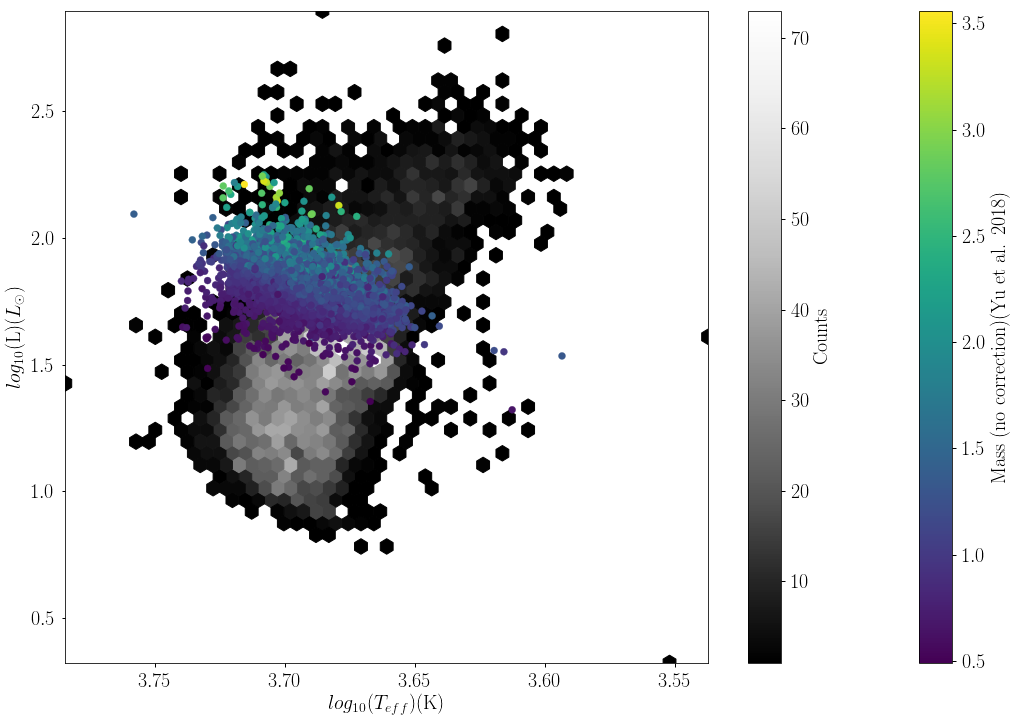

In [22]:
from omnitool.literature_values import Rsol, Msol, Lsol, Zsol
from omnitool import scalings

sc = scalings(xyu18, xyu18.numax, xyu18.dnu, xyu18. Teff)
xyu18['L'] = sc.get_luminosity()/Lsol
xyu18['L_err'] = sc.get_luminosity_err()/Lsol
sel = xyu18.stage != 2

fig, ax = plt.subplots(figsize=(18,12))
c1 = ax.hexbin(np.log10(xyu18[sel].Teff), np.log10(xyu18[sel].L),\
             gridsize=50, mincnt=1.,cmap='Greys_r', label='Non-CHeB')
c2 = ax.scatter(np.log10(rcxyu18.Teff), np.log10(rcxyu18.L),\
            c=rcxyu18.M_noCorrection, cmap='viridis', label='CHeB subset')

fig.colorbar(c2,label='Mass (no correction)(Yu et al. 2018)')
fig.colorbar(c1,label='Counts')
ax.invert_xaxis()
ax.set_xlabel(r'$log_{10}(T_{eff})$(K)')
ax.set_ylabel(r'$log_{10}$(L)($L_\odot$)')
plt.show()

# Plots, investigation, and other code snippets

Number of seats in use : 1/5.
Number of seats in use : 2/5.
Number of seats in use : 3/5.
Number of seats in use : 4/5.


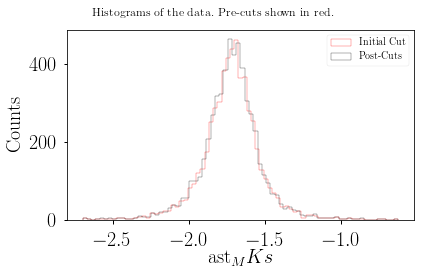

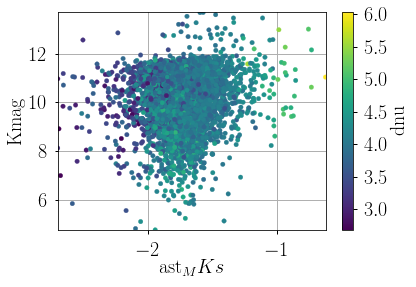

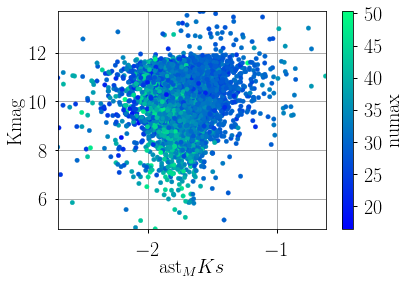

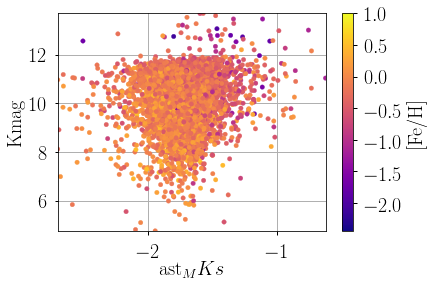

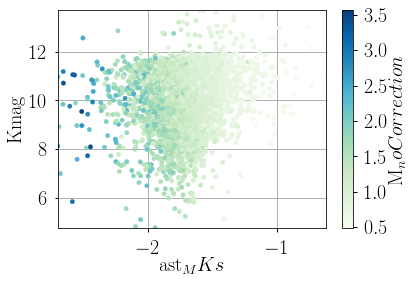

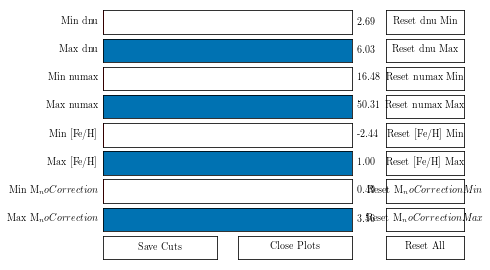

In [23]:
import barbershop
barber = barbershop.open(rcxyu18, 'ast_MKs','Kmag')
barber.add_client('dnu')
barber.add_client('numax')
barber.add_client('[Fe/H]')
barber.add_client('M_noCorrection')
barber.histograms_on(x=True)
barber.show_mirror()

NameError: name 'rcxyu18_final' is not defined

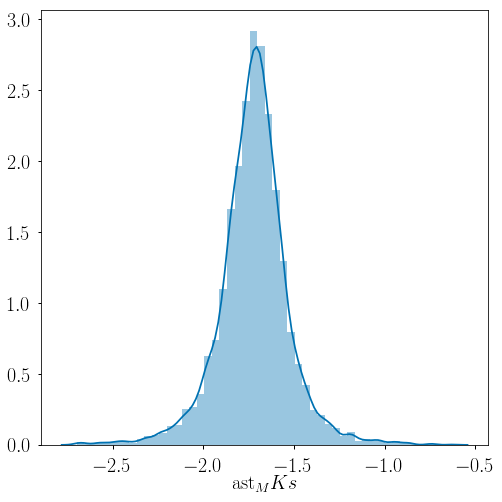

In [24]:
fig = plt.figure(figsize=(8,8))
sns.distplot(rcxyu18.ast_MKs, label='Yu18 RC classified (5578 stars)')
sns.distplot(rcxyu18_final.ast_MKs, label='Elsworth Classified (7497 stars)')
plt.xlabel('Asteroseismic Absmag in Ks')
plt.title('Comparing Yu+18 and Elsworth classifications',fontsize=20)
plt.legend(fontsize=20)
plt.show()

Save for future use, if necessary!

## Now lets run a quick barbershop on it to see how the secondary clump and higher metallicities affect our sample

In [ ]:
sys.exit()

In [ ]:
list(elsxrcxyu18)
elsxrcxyu18.duplicated_source

In [ ]:
rcxyu18.head(2)

In [ ]:
sel = np.isfinite(rcxyu18.Kmag)
%pylab qt
import barbershop
barber = barbershop.open(rcxyu18[sel],'ast_MKs','Kmag')
barber.add_client('dnu')
barber.add_client('M')
barber.histograms_on(x=True,y=True)
barber.show_mirror()
plt.show()